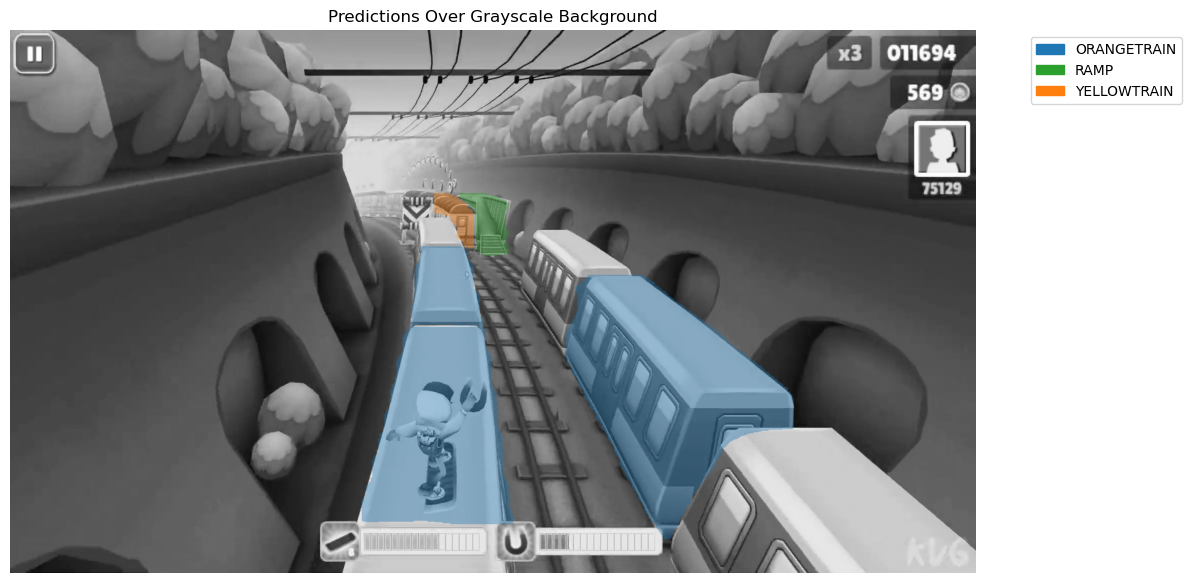

In [51]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib
import os
from dotenv import load_dotenv
from inference_sdk import InferenceHTTPClient

def run_tinder(img):
    # === CONFIG ===
    load_dotenv(dotenv_path="/Users/marcus/SubwaySurfersAi/.env")
    IMAGE = img
    MODEL_ID = "my-first-project-oov5d/1"
    API_KEY = os.getenv('ROBOFLOW_API_KEY')
    
    # === Init client ===
    CLIENT = InferenceHTTPClient(
        api_url="https://serverless.roboflow.com",
        api_key=API_KEY
    )
    
    # === Run inference ===
    result = CLIENT.infer(IMAGE, model_id=MODEL_ID)
    
    # === Load image and prepare grayscale background ===
    img_color = cv2.imread(IMAGE)
    img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
    img_gray_3ch = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)
    
    overlay = img_gray_3ch.copy()  # start with grayscale
    
    # === Assign unique color to each class ===
    classes = list(set(pred['class'] for pred in result['predictions']))
    cmap = matplotlib.colormaps.get_cmap("tab10")
    
    color_map = {
        cls: tuple([int(c * 255) for c in cmap(i % 10)[:3]])
        for i, cls in enumerate(classes)
    }
    
    # === Draw predictions ===
    for pred in result['predictions']:
        label = pred['class']
        conf = pred['confidence']
        color = color_map[label]
    
        if 'points' in pred:
            points = np.array([(int(p['x']), int(p['y'])) for p in pred['points']], np.int32)
            cv2.fillPoly(overlay, [points], color=color)
    
        elif all(k in pred for k in ['x', 'y', 'width', 'height']):
            x = int(pred['x'] - pred['width'] / 2)
            y = int(pred['y'] - pred['height'] / 2)
            w = int(pred['width'])
            h = int(pred['height'])
            cv2.rectangle(overlay, (x, y), (x + w, y + h), color=color, thickness=-1)
    
    # === Blend mask over grayscale ===
    alpha = 0.4
    blended = cv2.addWeighted(overlay, alpha, img_gray_3ch, 1 - alpha, 0)
    
    # === Build legend ===
    legend_patches = [
        Patch(color=np.array(color_map[cls]) / 255.0, label=cls)
        for cls in sorted(color_map.keys())
    ]
    
    # === Display image ===
    plt.figure(figsize=(12, 8))
    plt.imshow(blended)
    plt.axis("off")
    plt.title("Predictions Over Grayscale Background")
    plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

run_tinder('train_screenshots/frame_0190.jpg')

